# Predict #
To be re-inserted into main Jupyter Notebook after.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For neural networks.
import keras as kr
# For data frames.
import pandas as pd
# For numerical arrays.
import numpy as np
# For preprocessing data.
import sklearn.preprocessing as pre
# For splitting data sets.
import sklearn.model_selection as mod
# For whitening.
import sklearn.decomposition as dec

Using TensorFlow backend.


In [2]:
# Import sklearn for comparison too
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [3]:
# Load the dataset into a dataframe
data = pd.DataFrame(data = load_boston().data, columns= load_boston().feature_names)
# Add the house price
data["MEDV"] = load_boston().target
# Quick check that all is ok
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


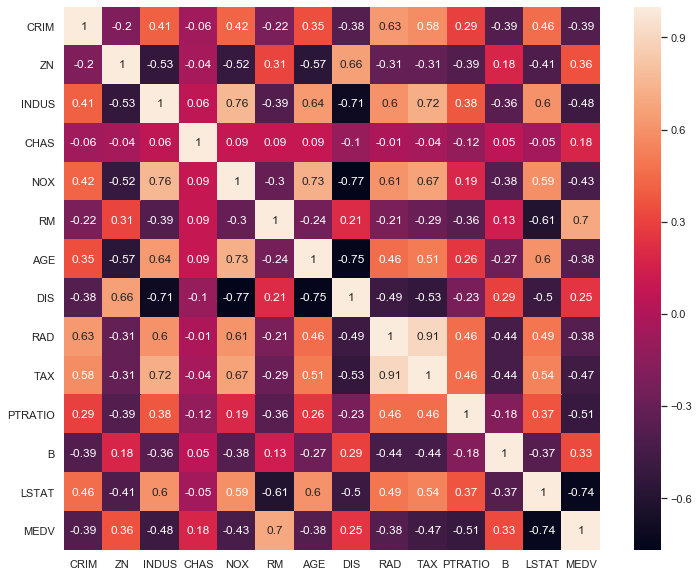

In [4]:
sns.set(rc={'figure.figsize':(12,10)})
correlation_matrix = data.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [5]:
correlation_matrix["MEDV"]

CRIM      -0.39
ZN         0.36
INDUS     -0.48
CHAS       0.18
NOX       -0.43
RM         0.70
AGE       -0.38
DIS        0.25
RAD       -0.38
TAX       -0.47
PTRATIO   -0.51
B          0.33
LSTAT     -0.74
MEDV       1.00
Name: MEDV, dtype: float64

In [6]:
cm = correlation_matrix.transform(func= lambda x: abs(x))["MEDV"].sort_values(ascending=False)
cm = cm.drop("MEDV",axis=0)
cm

LSTAT      0.74
RM         0.70
PTRATIO    0.51
INDUS      0.48
TAX        0.47
NOX        0.43
CRIM       0.39
RAD        0.38
AGE        0.38
ZN         0.36
B          0.33
DIS        0.25
CHAS       0.18
Name: MEDV, dtype: float64

Because the TAX and RAD parameters are highly correlated (0.91) both should not be  used in training any model. As TAX has a higher correlation than RAD, the RAD feature will be dropped.

In [7]:
cm = cm.drop("RAD",axis=0)
cm

LSTAT      0.74
RM         0.70
PTRATIO    0.51
INDUS      0.48
TAX        0.47
NOX        0.43
CRIM       0.39
AGE        0.38
ZN         0.36
B          0.33
DIS        0.25
CHAS       0.18
Name: MEDV, dtype: float64

In [28]:
# Putting all possible parameters in a list in order of correlation
params = []
for i in range(0, len(cm)):
    params.append(cm.index[i])

In [37]:
# Parameterise everything

# No of variables to include in predictions
noParams = 3 

# All the activations
acts = ["relu", "tanh", "sigmoid", "exp", "linear"]
act = acts[0]

# Optimisers
opts= ["sgd", "adam", "nadam"]
opt = opts[1]

noEpoch= 100
batchSize = 10

In [30]:
# Split the dataset into what we are using
x = data[params[:noParams]] # inputs
y = data['MEDV'] # outputs

In [31]:
# Split the dataset into training and testing
x_train, x_test, y_train, y_test = mod.train_test_split(x, y, test_size=0.3)

In [32]:
# Adding a scaler
scaler = pre.StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)

In [36]:
# Create our model
m = kr.models.Sequential()

m.add(kr.layers.Dense(20, input_dim=noParams, activation = act))
m.add(kr.layers.Dense(1, activation="linear"))

m.compile(loss = "mean_squared_error", optimizer =opt)

In [39]:
# Train the network
m.fit(x_train, y_train, epochs=noEpoch, batch_size=batchSize)

Epoch 1/100
354/354 [==============================] - 0s 481us/step - loss: 406.7161
Epoch 2/100
354/354 [==============================] - 0s 68us/step - loss: 286.0899
Epoch 3/100
354/354 [==============================] - 0s 76us/step - loss: 239.9000
Epoch 4/100
354/354 [==============================] - 0s 76us/step - loss: 201.8167
Epoch 5/100
354/354 [==============================] - 0s 87us/step - loss: 168.3561
Epoch 6/100
354/354 [==============================] - 0s 76us/step - loss: 143.5145
Epoch 7/100
354/354 [==============================] - 0s 73us/step - loss: 122.9312
Epoch 8/100
354/354 [==============================] - 0s 73us/step - loss: 106.4183
Epoch 9/100
354/354 [==============================] - 0s 79us/step - loss: 92.2636
Epoch 10/100
354/354 [==============================] - 0s 79us/step - loss: 80.8913
Epoch 11/100
354/354 [==============================] - 0s 73us/step - loss: 72.1558
Epoch 12/100
354/354 [==============================] - 0s 73us/s

354/354 [==============================] - 0s 66us/step - loss: 24.7940
Epoch 98/100
354/354 [==============================] - 0s 68us/step - loss: 24.7846
Epoch 99/100
354/354 [==============================] - 0s 65us/step - loss: 25.1913
Epoch 100/100
354/354 [==============================] - 0s 68us/step - loss: 24.9729


In [40]:
# Check to see how we do on test
m.predict(x_test).round().T

array([[21., 26., 40., 21., 33., 12., 10., 38., 42., 23., 11., 40., 28.,
        15., 17., 17., 22., 13., 17., 28., 17., 18., 17., 16., 16., 16.,
        17., 21., 16., 31., 31., 26., 33., 24., 41., 20., 16., 18., 18.,
        28., 14., 34., 39., 17., 19., 11., 31., 27., 29., 13., 21., 13.,
        21., 26., 40., 21., 14., 19., 30., 12., 13., 29., 25., 18., 14.,
        34., 24., 24., 28., 34., 30., 18., 16., 17., 18., 23., 12., 28.,
        31., 27., 18., 37., 26., 20., 23., 15., 24., 24., 12., 31., 19.,
        16., 32., 24., 17., 25., 15., 15., 25., 26., 13., 12., 25., 26.,
        27., 16., 30., 28., 15., 28., 16., 15., 25., 21., 25., 24., 24.,
        20., 14., 34., 19., 24., 30., 15.,  8., 13., 16., 16., 42., 15.,
        30., 14., 20., 29., 20., 21., 19., 13., 23., 33., 17., 34., 26.,
        22., 28., 17., 27., 37., 16., 21., 27., 18.]], dtype=float32)

In [43]:
# The actual test values
y_test.values.astype(np.float32)

array([20. , 25. , 42.8, 18.7, 35.4, 12.7,  7.2, 42.3, 41.7, 22.2,  5. ,
       50. , 26.2, 22.5,  9.6, 22. , 24. , 13.3, 18.7, 23.3, 19.1, 14.5,
       20. , 15.3, 12.1, 12.5, 19.6, 19. , 13.1, 30.1, 29.8, 22. , 28.5,
       50. , 50. , 19.4, 14.2, 24.4, 14.3, 26.6, 19.1, 31.7, 50. , 20.8,
       21.7, 21.9, 32.2, 26.4, 27. , 19.5, 21.2,  6.3, 22.9, 24.8, 37.6,
       19.2, 15.1, 23.2, 28.6,  8.5, 10.8, 23.7, 29.8, 20.7, 23.1, 31.5,
       23.1, 22.4, 23.9, 34.9, 29.4, 13.4, 16.1, 18.7, 17.4, 20.6, 14.4,
       24.7, 36.1, 29.1, 17.2, 46.7, 22. , 18.9, 18.5, 18.8, 23. , 23.8,
       11.8, 24. , 23.3, 11.8, 37.2, 25. , 14.9, 25. ,  8.7, 19.4, 30.7,
       22.3, 16.1, 20. , 23.9, 23.6, 26.5, 19.9, 26.6, 24.4, 20.1, 23.3,
       19.9, 16.5, 23.8, 24.7, 15. , 24.5, 22.2, 23.8, 17.3, 32.9, 20.6,
       23.9, 33. , 23.2, 13.8, 13.9, 18.3, 18.4, 50. , 17.8, 27.9, 12.7,
       18.5, 25. , 10.4, 22.8, 17.7,  5. , 36.2, 32. , 20.6, 34.7, 22.8,
       21.2, 23.1, 19.6, 22. , 44. , 17.5, 19.1, 24

In [44]:
# Calculate the loss function (Mean squared error in our case)
m.evaluate(x_test, y_test)

152/152 [==============================] - 0s 164us/step


22.16623276158383